# fbprophet

In [2]:
# Python
import pandas as pd
import numpy as np
from fbprophet import Prophet
import utils
import matplotlib
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation

%matplotlib inline

def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return np.sqrt(np.square(log_vars).mean())

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
trn = pd.read_csv('./data/air_visit_data.csv')
trn = trn.rename({
    'visit_date': 'ds',
    'visitors': 'y'
}, axis='columns')
trn['y'] = np.log(trn.y)
trn.head()

,air_store_id,ds,y
0,air_ba937bf13d40fb24,2016-01-13,3.218876
1,air_ba937bf13d40fb24,2016-01-14,3.465736
2,air_ba937bf13d40fb24,2016-01-15,3.367296
3,air_ba937bf13d40fb24,2016-01-16,3.091042
4,air_ba937bf13d40fb24,2016-01-18,1.791759


In [8]:
hol = pd.read_csv('./data/date_info.csv')
hol = hol.rename(
    {
        'calendar_date': 'Date',
    }, axis='columns')
hol.Date = pd.to_datetime(hol.Date)
hol = utils.add_ts_elapsed('holiday_flg', ['dur_'], hol)
calender = hol[['Date', 'holiday_flg', 'dur_holiday_flg']]
prophit_hol = calender[calender.holiday_flg == 1].rename({
    'dur_holiday_flg': 'holiday',
    'Date': 'ds'
},axis="columns").drop('holiday_flg', axis=1)
prophit_hol.holiday = prophit_hol.holiday.astype('str')

# Batch Train

In [2]:
result = pd.DataFrame()
stores = trn.groupby('air_store_id')
for i, store in stores:
    storeid = list(store.air_store_id.unique())[0]
#     print(store_df)
    print(str(count) + ' trainging :' + storeid)
    store = store.drop(columns=['air_store_id'])
    m = Prophet(holidays=prophit_hol, yearly_seasonality=False, daily_seasonality=False)
    m.fit(store)
    print(str(count) + 'predicting :' + storeid)
    forecast = m.predict(test_time_df)
    forecast['air_store_id'] = storeid
    forecast = forecast.rename({
        'ds':'visit_date',
        'yhat': 'visitors'
    }, axis='columns')
    forecast['visitors'] = np.exp(forecast.visitors) - 1
    count = count + 1
    result = result.append(forecast)

In [297]:
result.to_csv('./result/pp_result_2.csv')

In [298]:
result['visit_date'] = result['visit_date'].astype('str')

In [299]:
def trn2test(tes_in_trn):
    tes_in_trn['id'] = tes_in_trn[['air_store_id', 'visit_date']].apply(
        lambda x: '_'.join(x), axis=1)
    return tes_in_trn[['id', 'visitors']]

In [300]:
fr = trn2test(result[['air_store_id', 'visit_date', 'visitors']])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [327]:
fr.to_csv('./result/pp_submission.csv', index=False)

In [356]:
final_result = pd.merge(test.drop(columns=['visitors']), fr, how='left')

In [366]:
final_result.to_csv('./result/pp_submission.csv', index=False)

In [365]:
final_result.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.713417
1,air_00a91d42b08b08d9_2017-04-24,22.902539
2,air_00a91d42b08b08d9_2017-04-25,24.945218
3,air_00a91d42b08b08d9_2017-04-26,30.442141
4,air_00a91d42b08b08d9_2017-04-27,32.736847


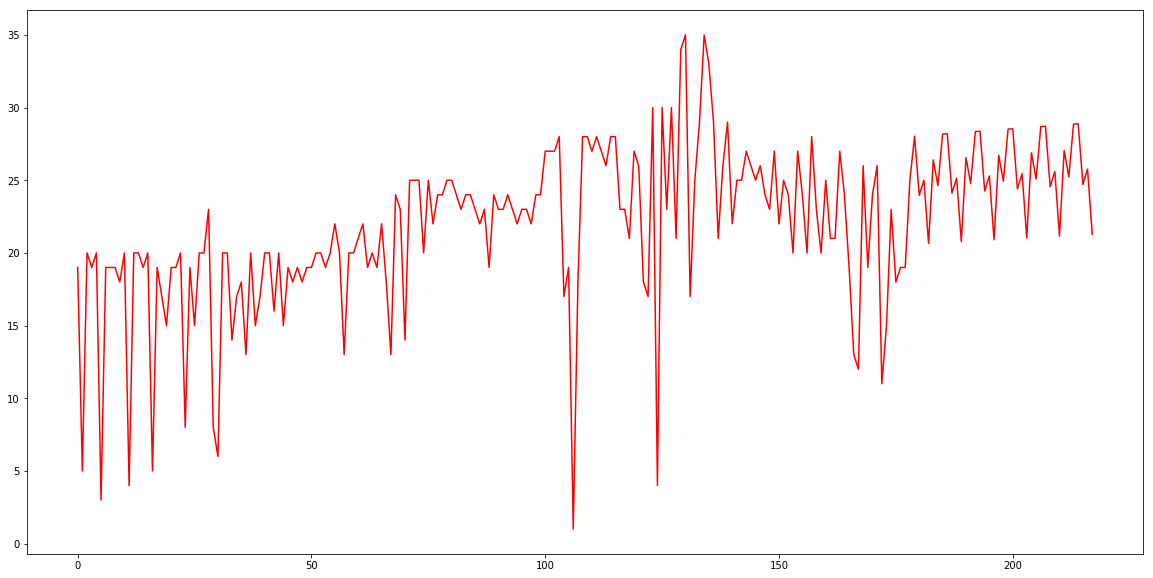

In [326]:
store_id = 'air_47beaffd3806c979'
store1 = data[data.air_store_id == store_id]
store1 = store1.drop(columns=['air_store_id'])
store1_predict = result[result.air_store_id == store_id]
# store1_predict.head()
store1.head()
total = pd.concat([store1.visitors, store1_predict.visitors])
plt.figure(figsize=(20, 10))
plt.plot(total.values, 'r')

# Tuning

In [28]:
test = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()

In [135]:
data_raw = pd.read_csv('./data/air_visit_data.csv')
data_raw = data_raw[data_raw.air_store_id.isin(test_stores)]
len(data)

250468

In [138]:
air_store_info = pd.read_csv('./data/air_store_info.csv')
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [205]:
data_n_store = pd.merge(data_raw, air_store_info, how='left')
data_n_store['vdt'] = pd.to_datetime(data_n_store.visit_date)
data_n_store['dow'] = data_n_store['vdt'].dt.dayofweek
data_n_store.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,vdt,dow
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-13,2
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-14,3
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-15,4
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-16,5
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-18,0


In [210]:
def getAreaMean(df):
    df['area_date_mean'] = np.mean(df.visitors.values)
    df['area_date_min'] = np.min(df.visitors.values)
    df['area_date_max'] = np.max(df.visitors.values)
    df['area_date_std'] = np.std(df.visitors.values)
    return df
def getAreaDowMean(df):
    df['area_dow_mean'] = np.mean(df.visitors.values)
    df['area_dow_min'] = np.min(df.visitors.values)
    df['area_dow_max'] = np.max(df.visitors.values)
    df['area_dow_std'] = np.std(df.visitors.values)
    return df
feas2 = data_n_store.groupby(by=['air_area_name', 'dow']).apply(getAreaDowMean)
feas2.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,vdt,dow,area_dow_mean,area_dow_min,area_dow_max,area_dow_std
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-13,2,20.309818,1,144,15.321100
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-14,3,19.922663,1,109,15.316330
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-15,4,23.509685,1,122,16.867322
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-16,5,19.964706,1,129,16.013558
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-18,0,15.201193,1,305,14.719473


In [211]:
feas2.to_csv('./data/area_dow_feas.csv', index=False)

In [212]:
data_with_feas = pd.merge(data_raw, feas2, how='left', 
                          left_on=['air_store_id', 'visit_date', 'visitors'],
                          right_on=['air_store_id', 'visit_date', 'visitors'])
data_with_feas.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,vdt,dow,area_dow_mean,area_dow_min,area_dow_max,area_dow_std
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-13,2,20.309818,1,144,15.321100
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-14,3,19.922663,1,109,15.316330
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-15,4,23.509685,1,122,16.867322
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-16,5,19.964706,1,129,16.013558
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-18,0,15.201193,1,305,14.719473


In [213]:
data = data_with_feas.rename({
    'visit_date': 'ds',
    'visitors': 'y'
}, axis='columns')
data['y'] = np.log(data.y)
data['area_dow_mean'] = np.log(data.area_dow_mean)
data['area_dow_max'] = np.log(data.area_dow_max)
data['area_dow_std'] = np.log(data.area_dow_std)
stores = data.air_store_id.unique()
hol = pd.read_csv('./data/date_info.csv')
hol = hol.rename(
    {
        'calendar_date': 'Date',
    }, axis='columns')
hol.Date = pd.to_datetime(hol.Date)
hol = utils.add_ts_elapsed('holiday_flg', ['dur_'], hol)
calender = hol[['Date', 'holiday_flg', 'dur_holiday_flg']]
prophit_hol = calender[calender.holiday_flg == 1].rename({
    'dur_holiday_flg': 'holiday',
    'Date': 'ds'
},axis="columns").drop('holiday_flg', axis=1)
prophit_hol.holiday = prophit_hol.holiday.astype('str')

In [215]:
# add data count for each store
def countData(df):
    return len(df)
gdata = data.groupby('air_store_id').apply(countData)
gdata = gdata.reset_index()
gdata = gdata.rename({
    0: 'data_count'
}, axis='columns')
gdata.head()
data = pd.merge(data, gdata, how='left')

In [230]:
dow_feas = feas2.groupby(['air_store_id', 'dow']).mean()
dow_feas = dow_feas.reset_index()

,air_store_id,dow,visitors,latitude,longitude,area_dow_mean,area_dow_min,area_dow_max,area_dow_std
4149,air_ba937bf13d40fb24,0,13.754386,35.658068,139.751599,15.201193,1.0,305.0,14.719473
4150,air_ba937bf13d40fb24,1,18.580645,35.658068,139.751599,18.047799,1.0,135.0,13.927373
4151,air_ba937bf13d40fb24,2,23.843750,35.658068,139.751599,20.309818,1.0,144.0,15.321100
4152,air_ba937bf13d40fb24,3,20.292308,35.658068,139.751599,19.922663,1.0,109.0,15.316330
4153,air_ba937bf13d40fb24,4,34.738462,35.658068,139.751599,23.509685,1.0,122.0,16.867322


In [279]:
test_data_raw = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test_data_raw)
test_data['visit_date'] = pd.to_datetime(test_data.visit_date)
test_data['dow'] = test_data.visit_date.dt.dayofweek
teat_data_with_dow = pd.merge(test_data, dow_feas,
                              how='left',
                              left_on=['air_store_id', 'dow'],
                              right_on=['air_store_id', 'dow'])
teat_data_with_dow = teat_data_with_dow.rename({
    'visit_date':'ds'
}, axis='columns')
teat_data_with_dow.head()

,air_store_id,ds,dow,visitors,latitude,longitude,area_dow_mean,area_dow_min,area_dow_max,area_dow_std
0,air_00a91d42b08b08d9,2017-04-23,6,2.000000,35.694003,139.753595,26.103448,1.0,130.0,20.566913
1,air_00a91d42b08b08d9,2017-04-24,0,22.457143,35.694003,139.753595,21.478093,1.0,113.0,15.421301
2,air_00a91d42b08b08d9,2017-04-25,1,24.350000,35.694003,139.753595,24.410341,1.0,142.0,16.674650
3,air_00a91d42b08b08d9,2017-04-26,2,28.125000,35.694003,139.753595,28.307943,1.0,136.0,18.588431
4,air_00a91d42b08b08d9,2017-04-27,3,29.868421,35.694003,139.753595,27.111483,1.0,113.0,17.662854


In [280]:
teat_data_with_dow['area_dow_mean'] = teat_data_with_dow.area_dow_mean.fillna(1)
teat_data_with_dow['area_dow_max'] = teat_data_with_dow.area_dow_max.fillna(1)
teat_data_with_dow['area_dow_std'] = teat_data_with_dow.area_dow_std.fillna(1)
teat_data_with_dow['area_dow_mean'] = np.log(teat_data_with_dow.area_dow_mean)
teat_data_with_dow['area_dow_max'] = np.log(teat_data_with_dow.area_dow_max)
teat_data_with_dow['area_dow_std'] = np.log(teat_data_with_dow.area_dow_std)
teat_data_with_dow[teat_data_with_dow.area_dow_mean.isna()]

,air_store_id,ds,dow,visitors,latitude,longitude,area_dow_mean,area_dow_min,area_dow_max,area_dow_std


In [254]:
#get test result
# result = pd.DataFrame()
# stores = teat_data_with_dow.groupby('air_store_id')
# stores.head()
trn_set = data
def getStoreTestResult(storeid):
    m = Prophet(holidays=prophit_hol, 
                yearly_seasonality=False, 
                daily_seasonality=False, 
                weekly_seasonality=True)
    m.add_regressor('area_dow_mean')
    m.add_regressor('area_dow_max')
    m.add_regressor('area_dow_std')
    m.fit(trn_set[trn_set.air_store_id == storeid])
    forecast = m.predict(teat_data_with_dow[teat_data_with_dow.air_store_id == storeid])
    forecast['air_store_id'] = storeid
    forecast = forecast.rename({
        'ds':'visit_date',
        'yhat': 'visitors'
    }, axis='columns')
    forecast['visitors'] = np.exp(forecast.visitors)
    return forecast

In [281]:
## pridect mul
test_result = {}
from multiprocessing import Pool
concurrency = 3
step_task = 1
test_stores = teat_data_with_dow.air_store_id.unique()
num_tasks = len(test_stores)
with Pool(concurrency) as pool:
    for i, res in enumerate(pool.imap(getStoreTestResult, test_stores), 1):
        test_result[i] = res
        if i % step_task == 0:
            print("progress={} %".format(i/num_tasks*100))

progress=0.12180267965895249 %
progress=0.24360535931790497 %
progress=0.3654080389768575 %
progress=0.48721071863580995 %
progress=0.6090133982947624 %
progress=0.730816077953715 %
progress=0.8526187576126675 %
progress=0.9744214372716199 %
progress=1.0962241169305724 %
progress=1.2180267965895248 %
progress=1.3398294762484775 %
progress=1.46163215590743 %
progress=1.5834348355663823 %
progress=1.705237515225335 %
progress=1.8270401948842874 %
progress=1.9488428745432398 %
progress=2.0706455542021924 %
progress=2.192448233861145 %
progress=2.3142509135200973 %
progress=2.4360535931790497 %
progress=2.5578562728380025 %
progress=2.679658952496955 %
progress=2.8014616321559074 %
progress=2.92326431181486 %
progress=3.0450669914738127 %
progress=3.1668696711327646 %
progress=3.2886723507917175 %
progress=3.41047503045067 %
progress=3.5322777101096223 %
progress=3.6540803897685747 %
progress=3.7758830694275276 %
progress=3.8976857490864796 %
progress=4.019488428745433 %
progress=4.1412911

progress=33.982947624847746 %
progress=34.104750304506695 %
progress=34.22655298416565 %
progress=34.348355663824606 %
progress=34.47015834348356 %
progress=34.59196102314251 %
progress=34.71376370280146 %
progress=34.835566382460414 %
progress=34.95736906211936 %
progress=35.07917174177832 %
progress=35.20097442143727 %
progress=35.32277710109623 %
progress=35.44457978075518 %
progress=35.56638246041413 %
progress=35.68818514007308 %
progress=35.80998781973204 %
progress=35.931790499390985 %
progress=36.05359317904993 %
progress=36.17539585870889 %
progress=36.297198538367844 %
progress=36.4190012180268 %
progress=36.54080389768575 %
progress=36.662606577344704 %
progress=36.78440925700365 %
progress=36.90621193666261 %
progress=37.028014616321556 %
progress=37.14981729598051 %
progress=37.27161997563947 %
progress=37.393422655298416 %
progress=37.51522533495737 %
progress=37.63702801461632 %
progress=37.758830694275275 %
progress=37.880633373934224 %
progress=38.00243605359318 %
prog

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


progress=54.56760048721072 %
progress=54.68940316686967 %
progress=54.81120584652862 %
progress=54.93300852618758 %
progress=55.05481120584653 %
progress=55.176613885505475 %
progress=55.29841656516443 %
progress=55.420219244823386 %
progress=55.54202192448234 %
progress=55.66382460414129 %
progress=55.785627283800245 %
progress=55.9074299634592 %
progress=56.02923264311814 %
progress=56.1510353227771 %
progress=56.27283800243605 %
progress=56.39464068209501 %
progress=56.51644336175396 %
progress=56.63824604141291 %
progress=56.76004872107187 %
progress=56.881851400730824 %
progress=57.003654080389765 %
progress=57.12545676004872 %
progress=57.247259439707676 %
progress=57.36906211936662 %
progress=57.49086479902557 %
progress=57.61266747868453 %
progress=57.734470158343484 %
progress=57.85627283800243 %
progress=57.97807551766139 %
progress=58.09987819732034 %
progress=58.2216808769793 %
progress=58.34348355663824 %
progress=58.465286236297196 %
progress=58.58708891595615 %
progress=

progress=89.15956151035323 %
progress=89.28136419001218 %
progress=89.40316686967114 %
progress=89.52496954933008 %
progress=89.64677222898904 %
progress=89.76857490864799 %
progress=89.89037758830695 %
progress=90.01218026796589 %
progress=90.13398294762484 %
progress=90.2557856272838 %
progress=90.37758830694276 %
progress=90.4993909866017 %
progress=90.62119366626065 %
progress=90.74299634591961 %
progress=90.86479902557856 %
progress=90.98660170523752 %
progress=91.10840438489647 %
progress=91.23020706455543 %
progress=91.35200974421437 %
progress=91.47381242387333 %
progress=91.59561510353228 %
progress=91.71741778319124 %
progress=91.83922046285018 %
progress=91.96102314250913 %
progress=92.08282582216809 %
progress=92.20462850182703 %
progress=92.32643118148599 %
progress=92.44823386114494 %
progress=92.5700365408039 %
progress=92.69183922046284 %
progress=92.81364190012181 %
progress=92.93544457978075 %
progress=93.05724725943972 %
progress=93.17904993909866 %
progress=93.30085

In [293]:
tr = pd.DataFrame()
for i in test_result.keys():
    tr = tr.append(test_result[i])
#     display(tr.head())

tr.head()

,visit_date,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,1,1_lower,1_upper,2,...,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,visitors,air_store_id
0,2017-04-23,2.971076,2.971076,2.971076,0.211029,1.455905,0.0,0.0,0.0,0.0,...,-2.120054,-2.120054,-1.607737,-1.607737,-1.607737,-1.607737,-1.607737,-1.607737,2.342039,air_00a91d42b08b08d9
1,2017-04-24,2.972005,2.972005,2.972005,2.480654,3.765945,0.0,0.0,0.0,0.0,...,0.147548,0.147548,-0.060805,-0.060805,-0.060805,-0.060805,-0.060805,-0.060805,22.636255,air_00a91d42b08b08d9
2,2017-04-25,2.972934,2.972930,2.972938,2.536501,3.834699,0.0,0.0,0.0,0.0,...,0.232706,0.232706,0.170265,0.170265,0.170265,0.170265,0.170265,0.170265,24.671285,air_00a91d42b08b08d9
3,2017-04-26,2.973864,2.973844,2.973878,2.807149,3.992411,0.0,0.0,0.0,0.0,...,0.446864,0.446864,0.415890,0.415890,0.415890,0.415890,0.415890,0.415890,30.591682,air_00a91d42b08b08d9
4,2017-04-27,2.974793,2.974761,2.974820,2.880230,4.168531,0.0,0.0,0.0,0.0,...,0.520081,0.520081,0.274048,0.274048,0.274048,0.274048,0.274048,0.274048,32.946149,air_00a91d42b08b08d9


In [317]:
def trn2test(tes_in_trn):
    tes_in_trn['ds'] = tes_in_trn.visit_date.astype('str')
    tes_in_trn['id'] = tes_in_trn[['air_store_id', 'ds']].apply(
        lambda x: '_'.join(x), axis=1)
    return tes_in_trn[["id", 'visitors', 'air_store_id', 'visit_date']]
tr_submission = trn2test(tr)
tr_submission.head()

,id,visitors,air_store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,2.342039,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,22.636255,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,24.671285,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,30.591682,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,32.946149,air_00a91d42b08b08d9,2017-04-27


In [305]:
# tr_submission.loc[tr_submission.visitors>120, 'visitors'] = 120
# tr_submission[tr_submission.visitors>120]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,id,visitors


In [319]:
tr_submission['dow'] = tr_submission.visit_date.dt.dayofweek
tr_submission_norm = pd.merge(tr_submission, dow_feas,
                              how='left',
                              left_on=['air_store_id', 'dow'],
                              right_on=['air_store_id', 'dow'])
tr_submission_norm.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,visitors_x,air_store_id,visit_date,dow,visitors_y,latitude,longitude,area_dow_mean,area_dow_min,area_dow_max,area_dow_std
0,air_00a91d42b08b08d9_2017-04-23,2.342039,air_00a91d42b08b08d9,2017-04-23,6,2.000000,35.694003,139.753595,26.103448,1.0,130.0,20.566913
1,air_00a91d42b08b08d9_2017-04-24,22.636255,air_00a91d42b08b08d9,2017-04-24,0,22.457143,35.694003,139.753595,21.478093,1.0,113.0,15.421301
2,air_00a91d42b08b08d9_2017-04-25,24.671285,air_00a91d42b08b08d9,2017-04-25,1,24.350000,35.694003,139.753595,24.410341,1.0,142.0,16.674650
3,air_00a91d42b08b08d9_2017-04-26,30.591682,air_00a91d42b08b08d9,2017-04-26,2,28.125000,35.694003,139.753595,28.307943,1.0,136.0,18.588431
4,air_00a91d42b08b08d9_2017-04-27,32.946149,air_00a91d42b08b08d9,2017-04-27,3,29.868421,35.694003,139.753595,27.111483,1.0,113.0,17.662854


In [306]:
tr_submission.to_csv('./result/pp_dow_reg_submission_rm_120.csv', index=False)

In [237]:
trn_set = data
# trn_set = data[data.ds < '2017-03-12']
# valid_set = data[data.ds >= '2017-03-12']
def testAStore(demo_store_id):
    trn = trn_set[trn_set.air_store_id == demo_store_id].copy()
#     data_count = trn.data_count.unique()[0]
    dl = len(trn)
    trn_len = int(np.floor(dl * 0.9))
    trn_data = trn[ :trn_len]
    valid_data = trn[trn_len: ]
    m0 = Prophet(holidays=prophit_hol, 
                yearly_seasonality=False,
                daily_seasonality=False,
                weekly_seasonality=True)

    m0.add_regressor('area_dow_mean')
    m0.add_regressor('area_dow_max')
    m0.add_regressor('area_dow_std')
    m0.fit(trn)
    forecast0 = m0.predict(valid_data)
    forecast1 = m0.predict(trn_data)
    loss0 = rmsle(np.exp(forecast0.yhat.values), np.exp(valid_data.y.values))
    loss1 = rmsle(np.exp(forecast1.yhat.values), np.exp(trn_data.y.values))

    return {
        'aire_store_id': demo_store_id, 
        'train_loss': loss1,
        'valid_loss': loss0, 
        'valid_len': dl - trn_len,
#         'data_count': data_count
    }

In [219]:
res = testAStore('air_b30fffd7ab1e75a5')

In [220]:
res

{'aire_store_id': 'air_b30fffd7ab1e75a5',
 'train_loss': 0.33973420648103397,
 'valid_len': 21,
 'valid_loss': 0.24253827954172313}

In [160]:
res

{'aire_store_id': 'air_b30fffd7ab1e75a5',
 'data_count': 202,
 'train_loss': 0.3395615786195133,
 'valid_len': 21,
 'valid_loss': 0.24207668438945007}

In [1662]:
res

{'aire_store_id': 'air_b30fffd7ab1e75a5',
 'data_count': 202,
 'train_loss': 0.33940005910608251,
 'valid_len': 21,
 'valid_loss': 0.24238757307924863}

In [238]:
## pridect mul
result = {}
from multiprocessing import Pool
concurrency = 3
step_task = 1
stores = data.air_store_id.unique()
num_tasks = len(stores)
with Pool(concurrency) as pool:
    for i, res in enumerate(pool.imap(testAStore, stores), 1):
        result[i] = res
        if i % step_task == 0:
            print("progress={} %".format(i/num_tasks*100))

progress=0.12180267965895249 %
progress=0.24360535931790497 %
progress=0.3654080389768575 %
progress=0.48721071863580995 %
progress=0.6090133982947624 %
progress=0.730816077953715 %
progress=0.8526187576126675 %
progress=0.9744214372716199 %
progress=1.0962241169305724 %
progress=1.2180267965895248 %
progress=1.3398294762484775 %
progress=1.46163215590743 %
progress=1.5834348355663823 %
progress=1.705237515225335 %
progress=1.8270401948842874 %
progress=1.9488428745432398 %
progress=2.0706455542021924 %
progress=2.192448233861145 %
progress=2.3142509135200973 %
progress=2.4360535931790497 %
progress=2.5578562728380025 %
progress=2.679658952496955 %
progress=2.8014616321559074 %
progress=2.92326431181486 %
progress=3.0450669914738127 %
progress=3.1668696711327646 %
progress=3.2886723507917175 %
progress=3.41047503045067 %
progress=3.5322777101096223 %
progress=3.6540803897685747 %
progress=3.7758830694275276 %
progress=3.8976857490864796 %
progress=4.019488428745433 %
progress=4.1412911

progress=33.982947624847746 %
progress=34.104750304506695 %
progress=34.22655298416565 %
progress=34.348355663824606 %
progress=34.47015834348356 %
progress=34.59196102314251 %
progress=34.71376370280146 %
progress=34.835566382460414 %
progress=34.95736906211936 %
progress=35.07917174177832 %
progress=35.20097442143727 %
progress=35.32277710109623 %
progress=35.44457978075518 %
progress=35.56638246041413 %
progress=35.68818514007308 %
progress=35.80998781973204 %
progress=35.931790499390985 %
progress=36.05359317904993 %
progress=36.17539585870889 %
progress=36.297198538367844 %
progress=36.4190012180268 %
progress=36.54080389768575 %
progress=36.662606577344704 %
progress=36.78440925700365 %
progress=36.90621193666261 %
progress=37.028014616321556 %
progress=37.14981729598051 %
progress=37.27161997563947 %
progress=37.393422655298416 %
progress=37.51522533495737 %
progress=37.63702801461632 %
progress=37.758830694275275 %
progress=37.880633373934224 %
progress=38.00243605359318 %
prog

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


progress=62.85018270401949 %
progress=62.971985383678444 %
progress=63.0937880633374 %
progress=63.21559074299634 %
progress=63.337393422655296 %
progress=63.45919610231425 %
progress=63.58099878197321 %
progress=63.702801461632156 %
progress=63.82460414129111 %
progress=63.94640682095007 %
progress=64.06820950060902 %
progress=64.19001218026796 %
progress=64.31181485992693 %
progress=64.43361753958587 %
progress=64.55542021924482 %
progress=64.67722289890378 %
progress=64.79902557856273 %
progress=64.92082825822169 %
progress=65.04263093788063 %
progress=65.16443361753959 %
progress=65.28623629719854 %
progress=65.40803897685748 %
progress=65.52984165651644 %
progress=65.6516443361754 %
progress=65.77344701583435 %
progress=65.89524969549329 %
progress=66.01705237515225 %
progress=66.1388550548112 %
progress=66.26065773447016 %
progress=66.38246041412911 %
progress=66.50426309378807 %
progress=66.62606577344702 %
progress=66.74786845310597 %
progress=66.86967113276492 %
progress=66.99

progress=97.442143727162 %
progress=97.56394640682095 %
progress=97.6857490864799 %
progress=97.80755176613886 %
progress=97.92935444579781 %
progress=98.05115712545675 %
progress=98.17295980511571 %
progress=98.29476248477467 %
progress=98.41656516443362 %
progress=98.53836784409256 %
progress=98.66017052375152 %
progress=98.78197320341047 %
progress=98.90377588306943 %
progress=99.02557856272838 %
progress=99.14738124238734 %
progress=99.2691839220463 %
progress=99.39098660170524 %
progress=99.51278928136419 %
progress=99.63459196102315 %
progress=99.7563946406821 %
progress=99.87819732034104 %
progress=100.0 %


In [239]:
r = pd.DataFrame()
r = r.from_dict(result, orient='index')

In [240]:
r.head()

,aire_store_id,train_loss,valid_loss,valid_len
1,air_ba937bf13d40fb24,0.394852,0.458910,40
2,air_25e9888d30b386df,0.611900,0.632166,32
3,air_8e4360a64dbd4c50,0.293262,0.250327,30
4,air_35512c42db0868da,0.420947,0.411588,42
5,air_a271c9ba19e81d17,0.427685,0.380660,30


In [241]:
len(r)


821

In [242]:
r.to_csv('./result/pp_cv_loss_trn_valid_dow_reg.csv')

In [243]:
!ls ./result

be_feat.csv                      pp_removed_80.csv
merge_xgb_prop.csv               pp_result.csv
model_bn.h5                      pp_result_2.csv
model_bn.yml                     pp_submission.csv
pp_cv_loss_part1.csv             pp_submission_501.csv
pp_cv_loss_part2.csv             submission.csv
pp_cv_loss_part3.csv             train_feas.csv
pp_cv_loss_trn_valid.csv         trn_features.csv
pp_cv_loss_trn_valid_dow_reg.csv tune_cv.csv
pp_model_compare.csv             valid_feas.csv
pp_model_compare_2.csv           valid_result.csv
pp_removed_100.csv               xgb.csv
pp_removed_120.csv               xgb_prop.csv


# Use weather regressor

In [26]:
test = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data_raw = pd.read_csv('./data/air_visit_data.csv')
data_raw = data_raw[data_raw.air_store_id.isin(test_stores)]
air_store_info = pd.read_csv('./data/air_store_info_with_nearest_active_station.csv')

In [4]:
len(test_data), len(data_raw), len(test_stores)

(32019, 250468, 821)

In [8]:
weather_data = pd.read_csv('./data/weather_data_merge.csv')
# weather_data.head()
# data = pd.merge(data_raw, air_store_info, how='left')
# data = data[['air_store_id', 'visit_date', 'visitors']]
# # data.head()
# data_with_weather = pd.merge(data, weather_data, how='left',
#                             left_on=['air_store_id', 'visit_date'],
#                             right_on=['air_store_id', 'visit_date']
#                             )
# data_with_weather.to_csv('./data/air_visit_data_with_weather.csv', index=False)

In [27]:
data_raw = pd.read_csv('./data/air_visit_data_with_weather.csv')
data_raw.columns

Index(['air_store_id', 'visit_date', 'visitors', 'avg_temperature',
       'high_temperature', 'low_temperature', 'precipitation',
       'hours_sunlight', 'solar_radiation', 'deepest_snowfall',
       'total_snowfall', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_local_pressure', 'avg_humidity', 'avg_sea_pressure', 'cloud_cover',
       'station_id', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_latitude',
       'station_longitude', 'station_vincenty', 'station_great_circle'],
      dtype='object')

In [28]:
data = data_raw[['air_store_id', 'visit_date', 'visitors', 
                 'avg_temperature', 'high_temperature', 'low_temperature', 
                 'precipitation', 'avg_wind_speed', 'deepest_snowfall']]

In [29]:
# data['avg_temperature'] = data.avg_temperature.fillna(0)
# data['high_temperature'] = data.high_temperature.fillna(0)
# data['low_temperature'] = data.low_temperature.fillna(0)
data['precipitation'] = data.precipitation.fillna(0)
data['deepest_snowfall'] = data.avg_wind_speed.fillna(0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
data['visit_date']

In [30]:
data = data.rename({
    'visit_date': 'ds',
    'visitors': 'y'
}, axis='columns')
data['y'] = np.log(data.y)
stores = data.air_store_id.unique()
hol = pd.read_csv('./data/date_info.csv')
hol = hol.rename(
    
    {
        'calendar_date': 'Date',
    }, axis='columns')
hol.Date = pd.to_datetime(hol.Date)
hol = utils.add_ts_elapsed('holiday_flg', ['dur_'], hol)
calender = hol[['Date', 'holiday_flg', 'dur_holiday_flg']]
prophit_hol = calender[calender.holiday_flg == 1].rename({
    'dur_holiday_flg': 'holiday',
    'Date': 'ds'
},axis="columns").drop('holiday_flg', axis=1)
prophit_hol.holiday = prophit_hol.holiday.astype('str')
data.head()

,air_store_id,ds,y,avg_temperature,high_temperature,low_temperature,precipitation,avg_wind_speed,deepest_snowfall
0,air_ba937bf13d40fb24,2016-01-13,3.218876,4.3,9.7,-0.9,0.0,1.7,1.7
1,air_ba937bf13d40fb24,2016-01-14,3.465736,6.0,11.4,0.2,0.0,2.0,2.0
2,air_ba937bf13d40fb24,2016-01-15,3.367296,5.6,10.9,2.0,0.0,2.5,2.5
3,air_ba937bf13d40fb24,2016-01-16,3.091042,6.5,11.8,1.8,0.0,1.9,1.9
4,air_ba937bf13d40fb24,2016-01-18,1.791759,2.8,6.2,0.2,67.0,3.7,3.7


In [186]:
trn_set = data
# trn_set = data[data.ds < '2017-03-12']
# valid_set = data[data.ds >= '2017-03-12']
def validAStore(demo_store_id):
    trn = trn_set[trn_set.air_store_id == demo_store_id].copy()
#     data_count = trn.data_count.unique()[0]
    dl = len(trn)
    trn_len = int(np.floor(dl * 0.9))
    trn_data = trn[ :trn_len]
    valid_data = trn[trn_len: ]
    m0 = Prophet(holidays=prophit_hol, 
                yearly_seasonality=False,
                daily_seasonality=False,
                weekly_seasonality=True)
    m0.add_regressor('precipitation')
    m0.fit(trn)
    forecast_valid_0 = m0.predict(valid_data)
    forecast_train_0 = m0.predict(trn_data)
    loss_valid_0 = rmsle(np.exp(forecast_valid_0.yhat.values), np.exp(valid_data.y.values))
    loss_train_0 = rmsle(np.exp(forecast_train_0.yhat.values), np.exp(trn_data.y.values))

    m1 = Prophet(holidays=prophit_hol, 
                yearly_seasonality=True,
                daily_seasonality=False,
                weekly_seasonality=True)
    m1.add_regressor('precipitation')
    m1.fit(trn)
    forecast_valid_1 = m1.predict(valid_data)
    forecast_train_1 = m1.predict(trn_data)
    loss_valid_1 = rmsle(np.exp(forecast_valid_1.yhat.values), np.exp(valid_data.y.values))
    loss_train_1 = rmsle(np.exp(forecast_train_1.yhat.values), np.exp(trn_data.y.values))
    return {
        'aire_store_id': demo_store_id, 
        'loss_valid_0': loss_valid_0,
        'loss_train_0': loss_train_0, 
        'loss_valid_1': loss_valid_1,
        'loss_train_1': loss_train_1, 
        'valid_len': dl - trn_len,
        'data_count': dl,
    }

In [187]:
res = validAStore('air_fef9ccb3ba0da2f7')

In [182]:
res

{'aire_store_id': 'air_fef9ccb3ba0da2f7',
 'data_count': 245,
 'loss_train_0': 0.45845016700214869,
 'loss_train_1': 0.43729729925862787,
 'loss_valid_0': 0.57774319878419667,
 'loss_valid_1': 0.48702976636084533,
 'valid_len': 25}

In [188]:
## pridect mul
result = {}
from multiprocessing import Pool
concurrency = 3
step_task = 1
stores = data.air_store_id.unique()
num_tasks = len(stores)
with Pool(concurrency) as pool:
    for i, res in enumerate(pool.imap(validAStore, stores), 1):
        result[i] = res
        if i % step_task == 0:
            print("progress={} %".format(i/num_tasks*100))

progress=0.12180267965895249 %
progress=0.24360535931790497 %
progress=0.3654080389768575 %
progress=0.48721071863580995 %
progress=0.6090133982947624 %
progress=0.730816077953715 %
progress=0.8526187576126675 %
progress=0.9744214372716199 %
progress=1.0962241169305724 %
progress=1.2180267965895248 %
progress=1.3398294762484775 %
progress=1.46163215590743 %
progress=1.5834348355663823 %
progress=1.705237515225335 %
progress=1.8270401948842874 %
progress=1.9488428745432398 %
progress=2.0706455542021924 %
progress=2.192448233861145 %
progress=2.3142509135200973 %
progress=2.4360535931790497 %
progress=2.5578562728380025 %
progress=2.679658952496955 %
progress=2.8014616321559074 %
progress=2.92326431181486 %
progress=3.0450669914738127 %
progress=3.1668696711327646 %
progress=3.2886723507917175 %
progress=3.41047503045067 %
progress=3.5322777101096223 %
progress=3.6540803897685747 %
progress=3.7758830694275276 %
progress=3.8976857490864796 %
progress=4.019488428745433 %
progress=4.1412911

progress=33.982947624847746 %
progress=34.104750304506695 %
progress=34.22655298416565 %
progress=34.348355663824606 %
progress=34.47015834348356 %
progress=34.59196102314251 %
progress=34.71376370280146 %
progress=34.835566382460414 %
progress=34.95736906211936 %
progress=35.07917174177832 %
progress=35.20097442143727 %
progress=35.32277710109623 %
progress=35.44457978075518 %
progress=35.56638246041413 %
progress=35.68818514007308 %
progress=35.80998781973204 %
progress=35.931790499390985 %
progress=36.05359317904993 %
progress=36.17539585870889 %
progress=36.297198538367844 %
progress=36.4190012180268 %
progress=36.54080389768575 %
progress=36.662606577344704 %
progress=36.78440925700365 %
progress=36.90621193666261 %
progress=37.028014616321556 %
progress=37.14981729598051 %
progress=37.27161997563947 %
progress=37.393422655298416 %
progress=37.51522533495737 %
progress=37.63702801461632 %
progress=37.758830694275275 %
progress=37.880633373934224 %
progress=38.00243605359318 %
prog

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


progress=62.85018270401949 %
progress=62.971985383678444 %


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


progress=63.0937880633374 %
progress=63.21559074299634 %
progress=63.337393422655296 %
progress=63.45919610231425 %
progress=63.58099878197321 %
progress=63.702801461632156 %
progress=63.82460414129111 %
progress=63.94640682095007 %
progress=64.06820950060902 %
progress=64.19001218026796 %
progress=64.31181485992693 %
progress=64.43361753958587 %
progress=64.55542021924482 %
progress=64.67722289890378 %
progress=64.79902557856273 %
progress=64.92082825822169 %
progress=65.04263093788063 %
progress=65.16443361753959 %
progress=65.28623629719854 %
progress=65.40803897685748 %
progress=65.52984165651644 %
progress=65.6516443361754 %
progress=65.77344701583435 %
progress=65.89524969549329 %
progress=66.01705237515225 %
progress=66.1388550548112 %
progress=66.26065773447016 %
progress=66.38246041412911 %
progress=66.50426309378807 %
progress=66.62606577344702 %
progress=66.74786845310597 %
progress=66.86967113276492 %
progress=66.99147381242388 %
progress=67.11327649208283 %
progress=67.235

progress=97.6857490864799 %
progress=97.80755176613886 %
progress=97.92935444579781 %
progress=98.05115712545675 %
progress=98.17295980511571 %
progress=98.29476248477467 %
progress=98.41656516443362 %
progress=98.53836784409256 %
progress=98.66017052375152 %
progress=98.78197320341047 %
progress=98.90377588306943 %
progress=99.02557856272838 %
progress=99.14738124238734 %
progress=99.2691839220463 %
progress=99.39098660170524 %
progress=99.51278928136419 %
progress=99.63459196102315 %
progress=99.7563946406821 %
progress=99.87819732034104 %
progress=100.0 %


In [189]:
r = pd.DataFrame()
r = r.from_dict(result, orient='index')
r.head()

,aire_store_id,loss_valid_0,loss_train_0,loss_valid_1,loss_train_1,valid_len,data_count
1,air_ba937bf13d40fb24,0.458348,0.394076,0.458692,0.388180,40,391
2,air_25e9888d30b386df,0.637706,0.614940,0.613821,0.588795,32,320
3,air_8e4360a64dbd4c50,0.251571,0.293011,0.254538,0.278239,30,293
4,air_35512c42db0868da,0.411084,0.420848,0.408851,0.395683,42,418
5,air_a271c9ba19e81d17,0.383281,0.426944,0.363585,0.412793,30,296


In [191]:
r.to_csv('./data/2model_loss.csv', index=False)

## Test

In [22]:
test_data_raw = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test_data_raw)
teat_data_with_weather = pd.merge(test_data, weather_data,
                              how='left',
                              left_on=['air_store_id', 'visit_date'],
                              right_on=['air_store_id', 'visit_date'])
teat_data_with_weather = teat_data_with_weather.rename({
    'visit_date':'ds'
}, axis='columns')
teat_data_with_weather.head()

,air_store_id,ds,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,...,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_00a91d42b08b08d9,2017-04-23,13.6,20.3,8.8,0.5,10.5,26.70,NaN,NaN,...,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",35.691667,139.75,0.416011,0.415906
1,air_00a91d42b08b08d9,2017-04-24,14.5,19.6,10.1,NaN,7.0,19.64,NaN,NaN,...,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",35.691667,139.75,0.416011,0.415906
2,air_00a91d42b08b08d9,2017-04-25,16.0,21.0,12.0,NaN,9.5,23.63,NaN,NaN,...,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",35.691667,139.75,0.416011,0.415906
3,air_00a91d42b08b08d9,2017-04-26,16.9,19.4,13.9,0.0,0.0,10.70,NaN,NaN,...,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",35.691667,139.75,0.416011,0.415906
4,air_00a91d42b08b08d9,2017-04-27,14.7,19.4,12.1,3.5,5.0,15.89,NaN,NaN,...,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",35.691667,139.75,0.416011,0.415906


In [23]:
models = pd.read_csv('./data/model_selection.csv')
models.head()

,aire_store_id,model
0,air_ba937bf13d40fb24,0
1,air_25e9888d30b386df,0
2,air_8e4360a64dbd4c50,0
3,air_35512c42db0868da,0
4,air_a271c9ba19e81d17,1


In [31]:
# teat_data_with_weather['avg_temperature'] = teat_data_with_weather.avg_temperature.fillna(0)
# teat_data_with_weather['high_temperature'] = teat_data_with_weather.high_temperature.fillna(0)
# teat_data_with_weather['low_temperature'] = teat_data_with_weather.low_temperature.fillna(0)
teat_data_with_weather['precipitation'] = teat_data_with_weather.precipitation.fillna(0)
teat_data_with_weather['deepest_snowfall'] = teat_data_with_weather.deepest_snowfall.fillna(0)
# teat_data_with_weather['avg_wind_speed'] = teat_data_with_weather.avg_wind_speed.fillna(0)

In [70]:
trn_set = data
def getStoreTestResult(storeid):
    if (models[models.aire_store_id == storeid].model.values[0] == 0 or len(trn_set[trn_set.air_store_id == storeid]) < 300):
        m = Prophet(holidays=prophit_hol, 
                    yearly_seasonality=False, 
                    daily_seasonality=False, 
                    weekly_seasonality=True)
    else:
        m = Prophet(holidays=prophit_hol, 
                    yearly_seasonality=True, 
                    daily_seasonality=False, 
                    weekly_seasonality=True)
    m.add_regressor('precipitation')
    m.fit(trn_set[trn_set.air_store_id == storeid])
    forecast = m.predict(teat_data_with_weather[teat_data_with_weather.air_store_id == storeid])
    forecast['air_store_id'] = storeid
    forecast = forecast.rename({
        'ds':'visit_date',
        'yhat': 'visitors'
    }, axis='columns')
    forecast['visitors'] = np.exp(forecast.visitors)
#     return m
    return forecast[['air_store_id', 'visit_date', 'visitors']]

In [ ]:
## pridect mul
test_result = {}
count = []
from multiprocessing import Pool
concurrency = 3
step_task = 1
test_stores = teat_data_with_weather.air_store_id.unique()
num_tasks = len(test_stores)
with Pool(concurrency) as pool:
    for i, res in enumerate(pool.imap(getStoreTestResult, test_stores), 1):
        test_result[i] = res
#         count.append(res)
        if i % step_task == 0:
            print("progress={} %".format(i/num_tasks*100))

progress=0.12180267965895249 %
progress=0.24360535931790497 %
progress=0.3654080389768575 %
progress=0.48721071863580995 %
progress=0.6090133982947624 %
progress=0.730816077953715 %
progress=0.8526187576126675 %
progress=0.9744214372716199 %
progress=1.0962241169305724 %
progress=1.2180267965895248 %
progress=1.3398294762484775 %
progress=1.46163215590743 %
progress=1.5834348355663823 %
progress=1.705237515225335 %
progress=1.8270401948842874 %
progress=1.9488428745432398 %
progress=2.0706455542021924 %
progress=2.192448233861145 %
progress=2.3142509135200973 %
progress=2.4360535931790497 %
progress=2.5578562728380025 %
progress=2.679658952496955 %
progress=2.8014616321559074 %
progress=2.92326431181486 %
progress=3.0450669914738127 %
progress=3.1668696711327646 %
progress=3.2886723507917175 %
progress=3.41047503045067 %
progress=3.5322777101096223 %
progress=3.6540803897685747 %
progress=3.7758830694275276 %
progress=3.8976857490864796 %
progress=4.019488428745433 %
progress=4.1412911

In [66]:
np.sum(count)

101

In [69]:
tr = pd.DataFrame()
for i in test_result.keys():
    tr = tr.append(test_result[i])
#     display(tr.head())

tr.head()

TypeError: cannot concatenate object of type "<class 'fbprophet.forecaster.Prophet'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [39]:
def trn2test(tes_in_trn):
    tes_in_trn['ds'] = tes_in_trn.visit_date.astype('str')
    tes_in_trn['id'] = tes_in_trn[['air_store_id', 'ds']].apply(
        lambda x: '_'.join(x), axis=1)
    return tes_in_trn[["id", 'visitors']]
tr_submission = trn2test(tr)
tr_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.410842
1,air_00a91d42b08b08d9_2017-04-24,22.828586
2,air_00a91d42b08b08d9_2017-04-25,25.000608
3,air_00a91d42b08b08d9_2017-04-26,30.586586
4,air_00a91d42b08b08d9_2017-04-27,32.933739


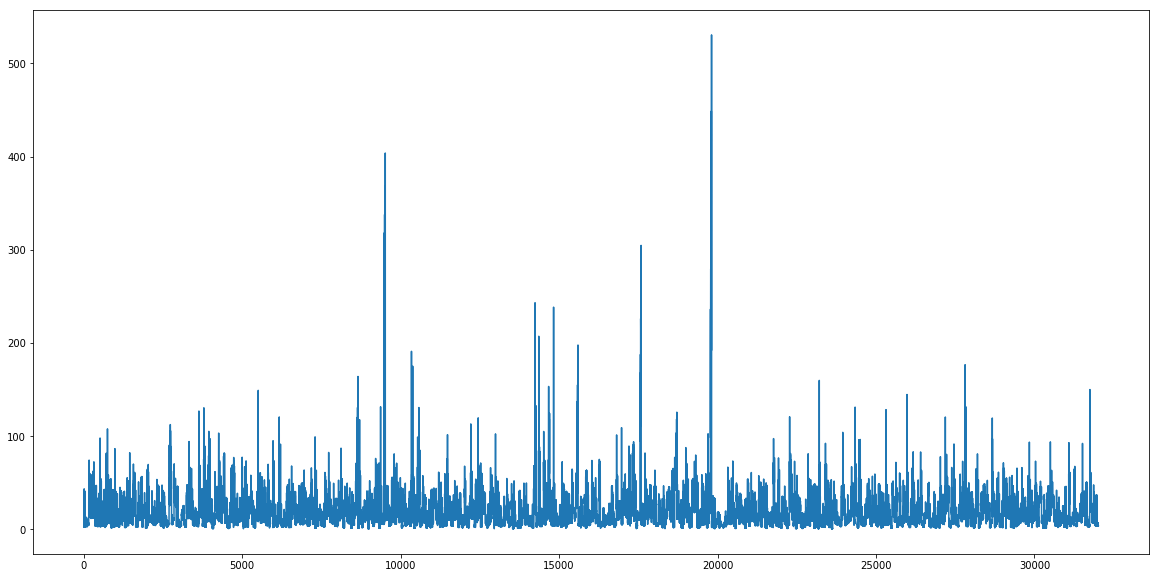

In [46]:
ttt = tr.reset_index()
plt.figure(figsize=(20, 10))
plt.plot(ttt.visitors)

In [48]:
# tr_submission[tr_submission.visitors > 120]
tr_submission.loc[tr_submission.visitors > 120, 'visitors'] = 120

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [49]:
tr_submission.to_csv('./result/pp_2model_rm_120.csv', index=False)

In [61]:
help(Prophet.add_regressor)

Help on function add_regressor in module fbprophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto')
    Add an additional regressor to be used for fitting and predicting.
    
    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    
    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: optional float scale for the normal prior. If not
        provided, self.holidays_prior_scale will be used.
    standardize: optional, specify whether this regressor will be
        standardized prior to fitting. Can be 'auto' (standardize if not
        binary), True, o


# Check Store

In [22]:
test = pd.read_csv('./data/sample_submission.csv')
test_rf = utils.tes2trn(test)

In [23]:
data = pd.read_csv('./data/air_visit_data.csv')
data = data.rename({
    'visit_date': 'ds',
    'visitors': 'y'
}, axis='columns')
data['y'] = np.log(data.y)
stores = data.air_store_id.unique()
hol = pd.read_csv('./data/date_info.csv')
hol = hol.rename(
    {
        'calendar_date': 'Date',
    }, axis='columns')
hol.Date = pd.to_datetime(hol.Date)
hol = utils.add_ts_elapsed('holiday_flg', ['dur_'], hol)
calender = hol[['Date', 'holiday_flg', 'dur_holiday_flg']]
prophit_hol = calender[calender.holiday_flg == 1].rename({
    'dur_holiday_flg': 'holiday',
    'Date': 'ds'
},axis="columns").drop('holiday_flg', axis=1)
prophit_hol.holiday = prophit_hol.holiday.astype('str')

In [24]:
store_id = 'air_23e1b11aee2a1407'

In [52]:
store_df = data[data.air_store_id == store_id].copy()
store_df = store_df[store_df.y > 1]
# store_df = store_df[store_df.y < 4.5]
predict_period = int(np.floor(len(store_df) * 0))
cap = np.max(store_df.y)
flr = 1
store_df['cap'] = cap
store_df['floor'] = flr
store_trn = store_df[:len(store_df) - predict_period]
store_valid = store_df[len(store_df) - predict_period:]
display(len(store_valid))
m = Prophet(holidays=prophit_hol, 
            yearly_seasonality=False,
            daily_seasonality=False,
            weekly_seasonality=True)
# m.add_seasonality(name='yearly', period=365, fourier_order=3)
m.fit(store_trn)
# df_cv = cross_validation(m, horizon = '20 days')
future = m.make_future_dataframe(periods=39)
future['cap'] = cap
future['floor'] = flr
forecast = m.predict(future)
simulate = m.predict(store_trn)
loss0 = rmsle(np.exp(simulate.yhat.values), np.exp(store_trn.y.values))
# loss = rmsle(np.exp(forecast[len(store_df) - predict_period:].yhat.values), np.exp(store_valid.y.values))
len(store_df), len(future), loss0, loss

0

(283, 322, 0.38422625437081459, nan)

In [61]:
forecast.columns

Index(['ds', 'trend', 'cap', 'trend_lower', 'trend_upper', 'yhat_lower',
       'yhat_upper', '1', '1_lower', '1_upper', '2', '2_lower', '2_upper', '3',
       '3_lower', '3_upper', '6', '6_lower', '6_upper', 'holidays',
       'holidays_lower', 'holidays_upper', 'seasonal', 'seasonal_lower',
       'seasonal_upper', 'seasonalities', 'seasonalities_lower',
       'seasonalities_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yhat'],
      dtype='object')

In [59]:
np.mean(store_df.y) + np.std(store_df.y) * 1.5

4.4138063849811244

In [37]:
# plt.figure(figsize = (30, 10))
# xaxis = store_valid.ds.apply(lambda x: str(x)[5:])
# plt.plot(xaxis.values, np.exp(store_valid.y.values), 'r-*')
# plt.plot(xaxis.values, np.exp(forecast[len(store_df) - predict_period:].yhat.values), '-*')
# plt.plot(xaxis.values, store_valid.y.values, 'r-*')
# plt.plot(store_trn[0:30].ds.values, simulate[0:30].yhat.values, '-*')
# plt.plot(store_trn[0:30].ds.values, store_trn[0:30].y.values, '-*')

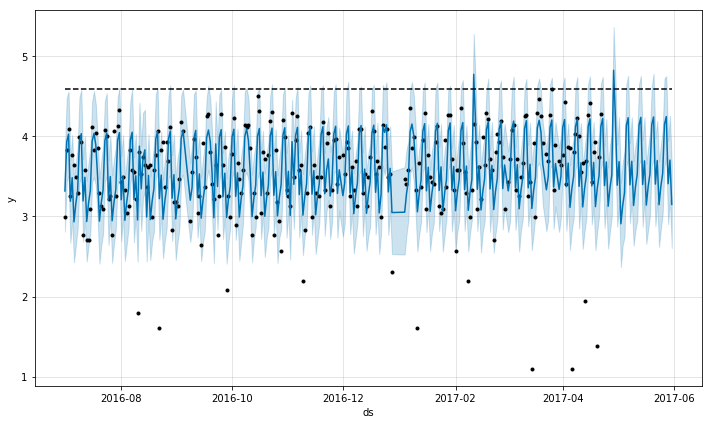

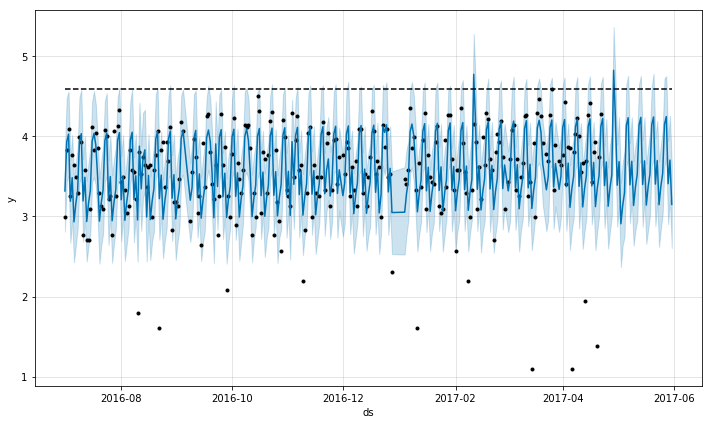

In [54]:
m.plot(forecast)

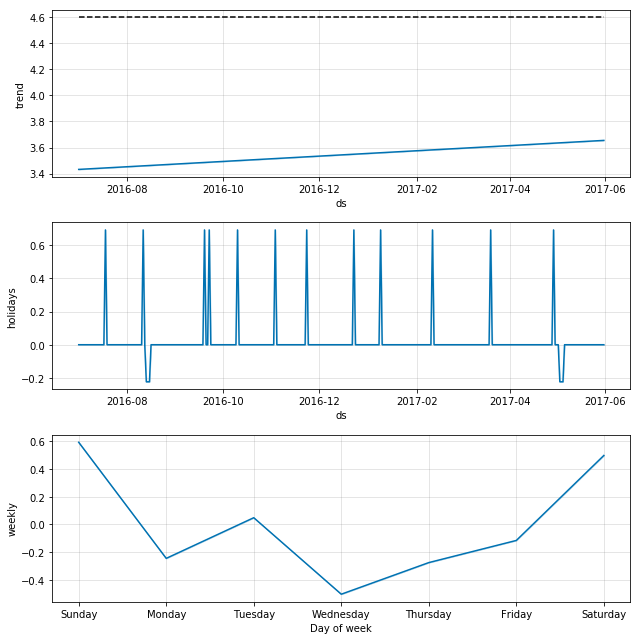

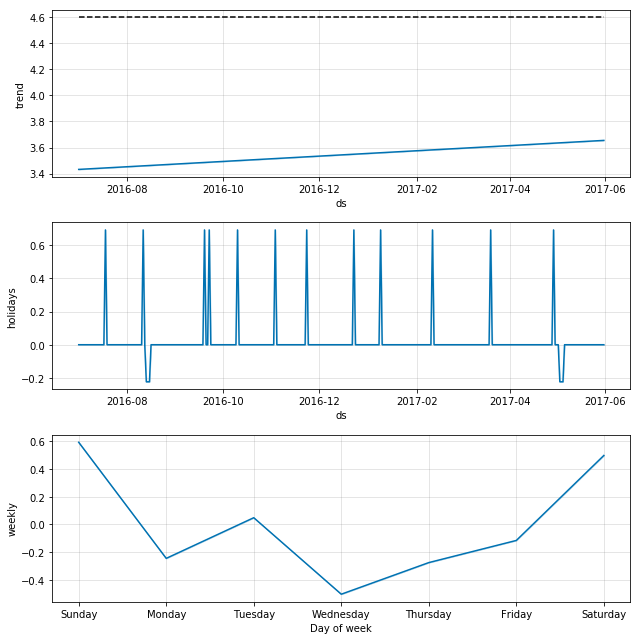

In [55]:
m.plot_components(forecast)

# get valid set

In [41]:
data_raw = pd.read_csv('./data/air_visit_data.csv')
test = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
tag_data = tag_data.set_index('index')
train_set = t[t.type == 0]
valid_set = t[t.type == 1]
len(train_set), len(train_set.air_store_id.unique()), len(valid_set), len(valid_set.air_store_id.unique())

(225049, 821, 25419, 821)

In [31]:
def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df

In [3]:
data_raw = pd.read_csv('./data/air_visit_data.csv')

(array([ 77154.,  70882.,  46569.,  27859.,  14308.,   8377.,   3760.,
          1574.,    700.,    385.]),
 array([  1. ,  10.8,  20.6,  30.4,  40.2,  50. ,  59.8,  69.6,  79.4,
         89.2,  99. ]),
 <a list of 10 Patch objects>)

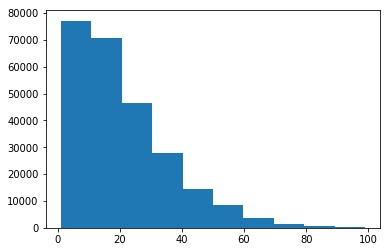

In [5]:
plt.hist(data_raw[data_raw.visitors<100].visitors)